In [12]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
import functools
%matplotlib inline

In [3]:
def create_toy_data(func, sample_size, std):
    x = np.linspace(0, 1, sample_size)
    t = func(x) + np.random.normal(scale=std, size=x.shape)
    return x, t

def func(x):
    return np.sin(2 * np.pi * x)

x_train, y_train = create_toy_data(func, 10, 0.25)
x_test = np.linspace(0, 1, 100)
y_test = func(x_test)

(a) Plot the graph with given code, the result should be same as this.

![](./images/originalData.png)

`x_train` and `y_train` are the datas you need to create, `sample_size` is 10 and `std` is 0.25. 

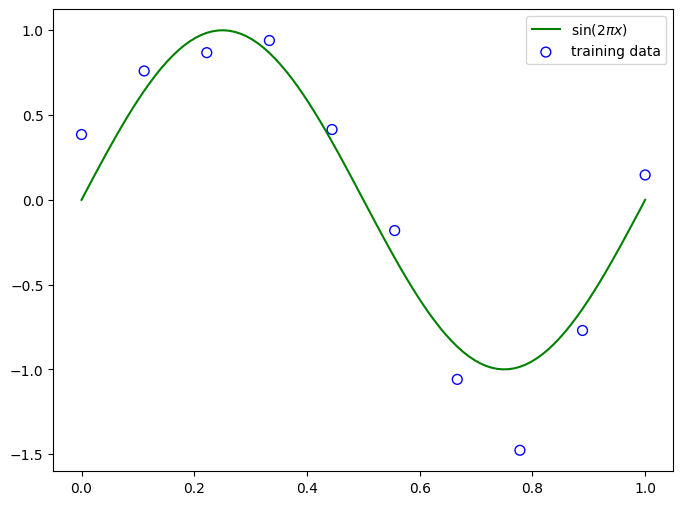

In [6]:
# Write you codes here.
plt.figure(figsize=(8, 6))
plt.plot(x_test, y_test, c="g", label="$\sin(2\pi x)$")
plt.scatter(x_train, y_train, facecolor="none", edgecolor="b", s=50, label="training data")
plt.legend()
plt.show()

(b) On the basis of the results, you should try $0^{th}$ order polynomial, $1^{st}$ order polynomial, $3^{rd}$ order polynomial and some other order polynomial, show the results include fitting and over-fitting.

![](./images/fitting.png)

In [13]:
class PolynomialFeature(object):

    def __init__(self, degree=2):
        assert isinstance(degree, int)
        self.degree = degree

    def transform(self, x):
        if x.ndim == 1:
            x = x[:, None]
        x_t = x.transpose()
        features = [np.ones(len(x))]
        for degree in range(1, self.degree + 1):
            for items in itertools.combinations_with_replacement(x_t, degree):
                features.append(functools.reduce(lambda x, y: x * y, items))
        return np.asarray(features).transpose()
    
class Regression(object):
    pass
    
class LinearRegression(Regression):

    def fit(self, X:np.ndarray, t:np.ndarray):
        self.w = np.linalg.pinv(X) @ t
        self.var = np.mean(np.square(X @ self.w - t))

    def predict(self, X:np.ndarray, return_std:bool=False):
        y = X @ self.w
        if return_std:
            y_std = np.sqrt(self.var) + np.zeros_like(y)
            return y, y_std
        return y

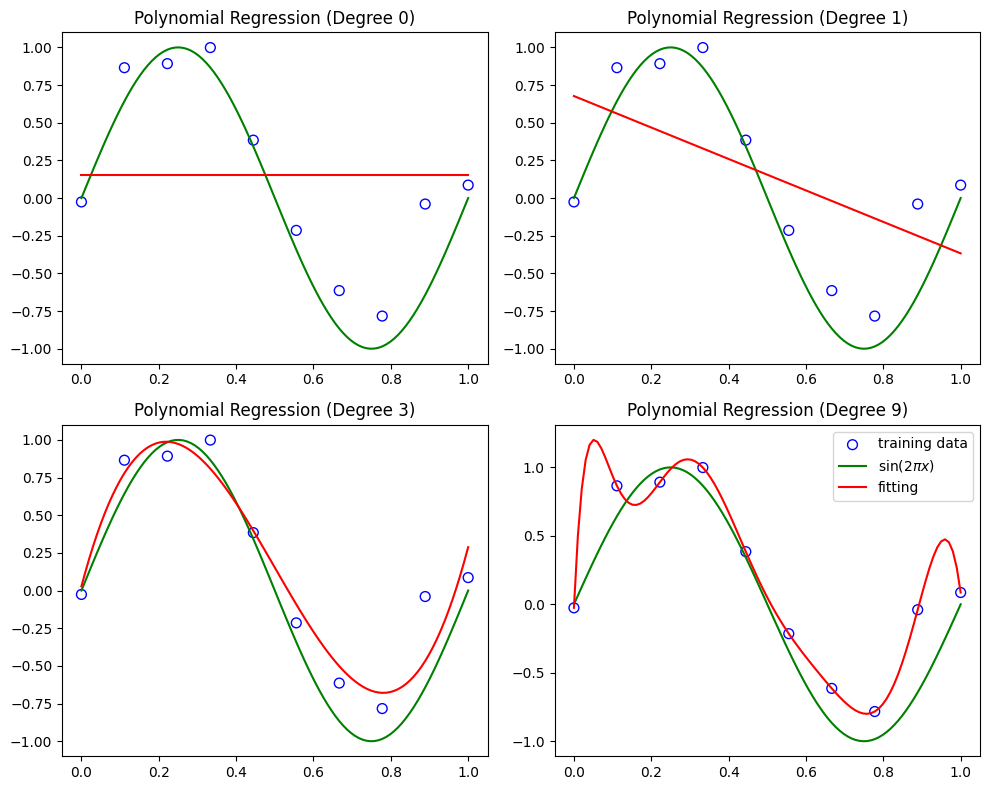

In [51]:
def visualize_polynomial_fit(x_train, y_train, x_test, y_test, degree, subplot_position):
    polynomial_features = PolynomialFeature(degree=degree)
    X_train_poly = polynomial_features.transform(x_train)
    X_test_poly = polynomial_features.transform(x_test)

    model = LinearRegression()
    model.fit(X_train_poly, y_train)
    y_pred = model.predict(X_test_poly)

    plt.subplot(2, 2, subplot_position)
    plt.scatter(x_train, y_train, facecolor="none", edgecolor="b", s=50, label="training data")
    plt.plot(x_test, y_test, c="g", label="$\sin(2\pi x)$")
    plt.plot(x_test, y_pred, c="r", label="fitting".format(degree))
    plt.title("Polynomial Regression (Degree {})".format(degree))

# Generate synthetic data
x_train, y_train = create_toy_data(func, 10, 0.25)
x_test = np.linspace(0, 1, 100)
y_test = func(x_test)

# Create a 2x2 subplot layout and visualize polynomial fits
plt.figure(figsize=(10, 8))

visualize_polynomial_fit(x_train, y_train, x_test, y_test, degree=0, subplot_position=1)
visualize_polynomial_fit(x_train, y_train, x_test, y_test, degree=1, subplot_position=2)
visualize_polynomial_fit(x_train, y_train, x_test, y_test, degree=3, subplot_position=3)
visualize_polynomial_fit(x_train, y_train, x_test, y_test, degree=9, subplot_position=4)

plt.legend()
plt.tight_layout()
plt.show()

(c) Plot the graph of the root-mean-square error.

![](./images/rmse.png)

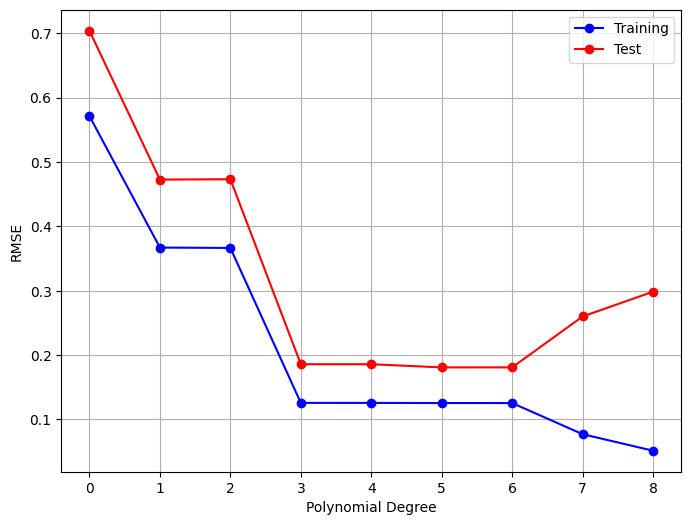

In [33]:
def rmse(a, b):
    return np.sqrt(np.mean((a - b) ** 2))

def fit_and_calculate_rmse(x_train, y_train, x_test, y_test, degree):
    polynomial_features = PolynomialFeature(degree=degree)
    X_train_poly = polynomial_features.transform(x_train)
    X_test_poly = polynomial_features.transform(x_test)

    model = LinearRegression()
    model.fit(X_train_poly, y_train)
    y_train_pred = model.predict(X_train_poly)
    y_test_pred = model.predict(X_test_poly)

    train_rmse = rmse(y_train, y_train_pred)
    test_rmse = rmse(y_test, y_test_pred)

    return train_rmse, test_rmse

x_train, y_train = create_toy_data(func, 10, 0.25)
x_test = np.linspace(0, 1, 100)
y_test = func(x_test)

# Calculate RMSE for different polynomial degrees
degrees = range(9)  # Polynomial degrees to evaluate
training_errors = []
test_errors = []

for degree in degrees:
    train_rmse, test_rmse = fit_and_calculate_rmse(x_train, y_train, x_test, y_test, degree)
    training_errors.append(train_rmse)
    test_errors.append(test_rmse)

# Plot the graph of RMSE
plt.figure(figsize=(8, 6))
plt.plot(degrees, training_errors, marker='o', label='Training',c="b")
plt.plot(degrees, test_errors, marker='o', label='Test',c="r")
plt.xlabel('Polynomial Degree')
plt.ylabel('RMSE')
plt.xticks(degrees)
plt.legend()
plt.grid()
plt.show()


(d) Plot the graph of the predictive distribution resulting from a Bayesian treatment of polynomial curve fitting using an M=9 polynomial, with the fixed parameters $\alpha=5\times 10^{-3}$ and $\beta=11.1$(corresponding to the known noise variance).

![](./images/bayesianRegression.png)

In [35]:
class BayesianRegression(Regression):
    def __init__(self, alpha: float = 1.0, beta: float = 1.0):
        self.alpha = alpha
        self.beta = beta
        self.w_mean = None
        self.w_precision = None

    def _is_prior_defined(self) -> bool:
        return self.w_mean is not None and self.w_precision is not None

    def _get_prior(self, ndim: int) -> tuple:
        if self._is_prior_defined():
            return self.w_mean, self.w_precision
        else:
            return np.zeros(ndim), self.alpha * np.eye(ndim)

    def fit(self, X: np.ndarray, t: np.ndarray):
        mean_prev, precision_prev = self._get_prior(np.size(X, 1))

        w_precision = precision_prev + self.beta * X.T @ X
        w_mean = np.linalg.solve(
            w_precision, precision_prev @ mean_prev + self.beta * X.T @ t
        )
        self.w_mean = w_mean
        self.w_precision = w_precision
        self.w_cov = np.linalg.inv(self.w_precision)

    def predict(self, X: np.ndarray, return_std: bool = False, sample_size: int = None):
        if sample_size is not None:
            w_sample = np.random.multivariate_normal(
                self.w_mean, self.w_cov, size=sample_size
            )
            y_sample = X @ w_sample.T
            return y_sample
        y = X @ self.w_mean
        if return_std:
            y_var = 1 / self.beta + np.sum(X @ self.w_cov * X, axis=1)
            y_std = np.sqrt(y_var)
            return y, y_std
        return y

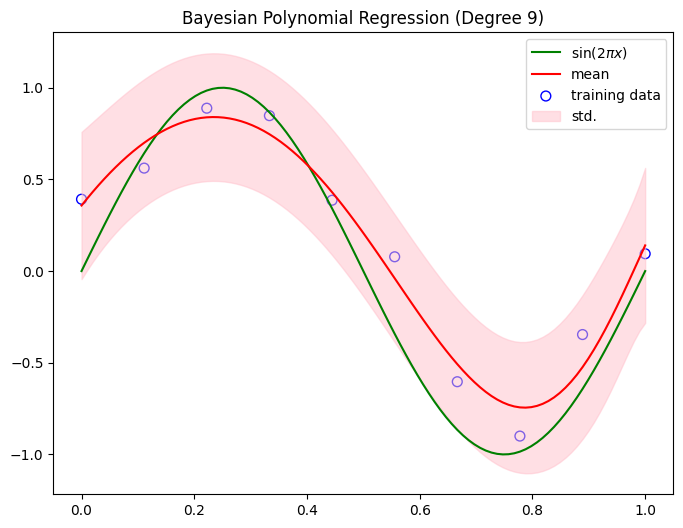

In [47]:
x_train, y_train = create_toy_data(func, 10, 0.25)
x_test = np.linspace(0, 1, 100)
y_test = func(x_test)

polynomial_features = PolynomialFeature(degree=9)
X_train_poly = polynomial_features.transform(x_train)
X_test_poly = polynomial_features.transform(x_test)

bayesian_model = BayesianRegression(alpha=5e-3, beta=11.1)
bayesian_model.fit(X_train_poly, y_train)

y_pred_mean, y_pred_std = bayesian_model.predict(X_test_poly, return_std=True)

plt.figure(figsize=(8, 6))
plt.plot(x_test, y_test, c="g", label="$\sin(2\pi x)$")
plt.plot(x_test, y_pred_mean, c="r", label="mean")
plt.scatter(
    x_train, y_train, facecolor="none", edgecolor="b", s=50, label="training data"
)
plt.fill_between(
    x_test,
    y_pred_mean - y_pred_std,
    y_pred_mean + y_pred_std,
    color="pink",
    alpha=0.5,
    label="std.",
)
plt.legend()
plt.title("Bayesian Polynomial Regression (Degree 9)")
plt.show()

(e) Change the $sample\_size$ to 2, 3 or 10 times than before, explain the change of $M$.

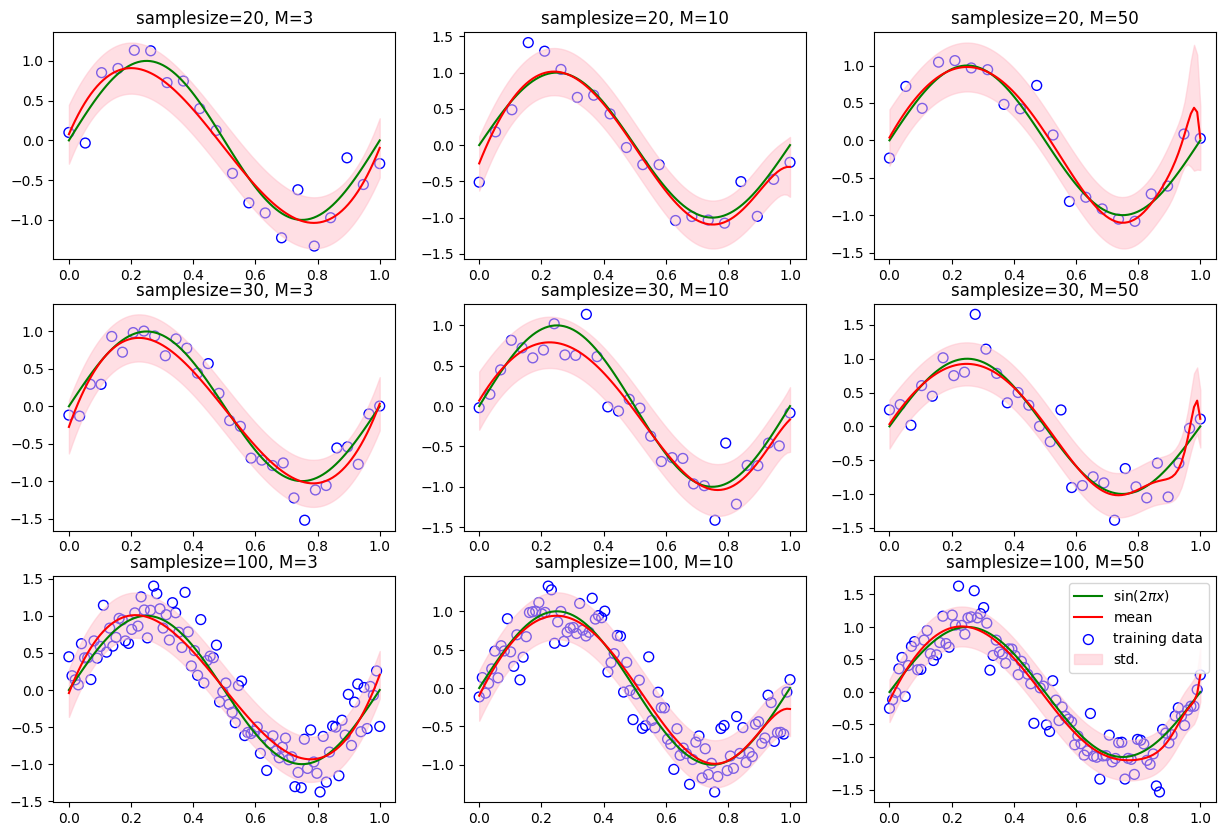

In [71]:
def draw_test_plots(sample_size, M, subplot_position):
    x_train, y_train = create_toy_data(func, sample_size, 0.25)
    x_test = np.linspace(0, 1, 100)
    y_test = func(x_test)

    polynomial_features = PolynomialFeature(degree=M)
    X_train_poly = polynomial_features.transform(x_train)
    X_test_poly = polynomial_features.transform(x_test)

    bayesian_model = BayesianRegression(alpha=5e-3, beta=11.1)
    bayesian_model.fit(X_train_poly, y_train)

    y_pred_mean, y_pred_std = bayesian_model.predict(X_test_poly, return_std=True)

    plt.subplot(3, 3, subplot_position)
    plt.plot(x_test, y_test, c="g", label="$\sin(2\pi x)$")
    plt.plot(x_test, y_pred_mean, c="r", label="mean")
    plt.scatter(
        x_train, y_train, facecolor="none", edgecolor="b", s=50, label="training data"
    )
    plt.fill_between(
        x_test,
        y_pred_mean - y_pred_std,
        y_pred_mean + y_pred_std,
        color="pink",
        alpha=0.5,
        label="std.",
    )
    plt.title("samplesize={}, M={}".format(sample_size,M))

plt.figure(figsize=(15, 10))
base_samplesize = 10
position_cnt = 0
for multiplier in [2, 3, 10]:
    for degree in [3, 10, 50]:
        position_cnt = position_cnt + 1
        draw_test_plots(multiplier * base_samplesize, degree, position_cnt)

plt.legend()
plt.show()


As sample size increases, the overfitting caused by higher degree $M$ become less obvious.

And for the same degree, the curve fits better with larger sample size.